<a href="https://colab.research.google.com/github/bragarods/rainfall_forecast/blob/master/notebooks/colab_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.display import clear_output
!pip3 install --upgrade pystan
!pip3 install --upgrade fbprophet
clear_output()

In [2]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

%matplotlib inline

plt.rcParams['figure.figsize'] = (13, 7)

## Import monthly data

In [3]:
# google drive shareable file link

orig_url = 'https://drive.google.com/file/d/1WQ9NARYCNZxWlQUAf4Zn5TxJcnOGjEn3/view?usp=sharing'

# get file id

file_id = orig_url.split('/')[-2]

# create download url

dwn_url='https://drive.google.com/uc?export=download&id=' + file_id

# get raw text inside url

url = requests.get(dwn_url).text

# create a buffer

csv_raw = StringIO(url)

# read from buffer

df = pd.read_csv(csv_raw, index_col=0)

df.reset_index(drop=True, inplace=True)

# create sinop and csinop series

df['date'] = pd.to_datetime(df['date'], format=('%Y-%m-%d')) 

#df.set_index('date', inplace=True)

## Flag first full year of data

In [5]:
df['chuva_max_12m'] = df.groupby('cd_estacao')['chuva'].rolling(12).max().reset_index(0,drop=True)

df['flag_chuva_max_12m'] = np.where((~df['chuva_max_12m'].isna()) & (df['chuva_max_12m'] >= 1),
                               1,
                               0)

fl_year = df[df['flag_chuva_max_12m']==1].groupby('cd_estacao').agg(min_year=('date','min'),
                                                                     max_year=('date','max'))

fl_year['min_year'] = fl_year['min_year'].dt.year+1
fl_year['max_year'] = fl_year['max_year'].dt.year

df = pd.merge(df,fl_year,how='left',left_on=df.cd_estacao,right_on=fl_year.index)

df.drop(columns='key_0', inplace=True)

df2009 = df[(df['min_year'] <= 2009) & (df['max_year'] >= 2020) & (df.date >= '2009-01-01')]

## Prophet

In [7]:
# preparing data for Prophet

strain = df2009.rename(columns={'date':'ds','chuva':'y'}).sort_values(['cd_estacao','ds']).reset_index(drop=True)

strain = strain[strain['ds']<='2019-12-01']

strain['floor'] = 0

In [26]:
from sklearn.metrics import mean_absolute_error

dict_model = {}
dff = pd.DataFrame([])

for cd_estacao in strain.cd_estacao.unique()[0:3]:
  m = Prophet()
  m.fit(strain[strain.cd_estacao == cd_estacao])
  dict_model[cd_estacao] = m
  future = m.make_future_dataframe(periods=12, freq='MS')
  forecast = m.predict(future)
  forecast['cd_estacao'] = cd_estacao
  forecast['mae'] = mean_absolute_error(df2009[(df2009.cd_estacao==cd_estacao) & (df2009.date >= '2009-01-01')].chuva, pd.Series(forecast.yhat[:-1]).clip(0))

  dff = dff.append(forecast)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


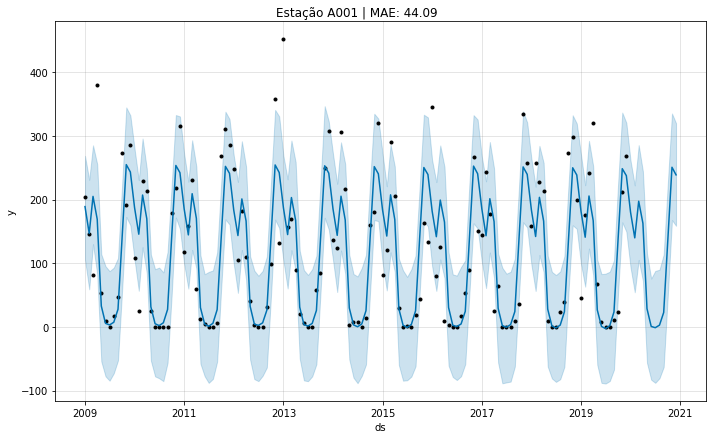

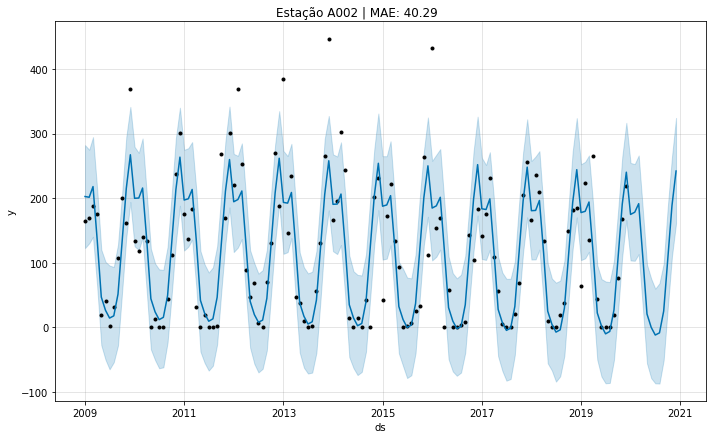

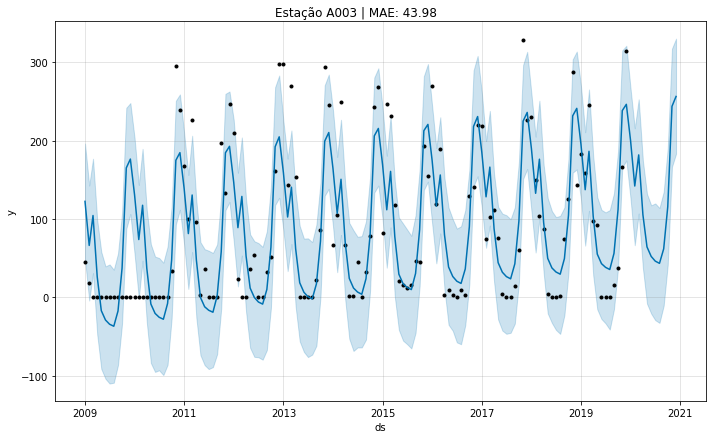

In [33]:
from fbprophet.plot import plot_plotly, plot_components_plotly

#plot_plotly(dict_model['A003'], dff[dff['cd_estacao']=='A003'])
for cd_estacao in dff.cd_estacao.unique():
  fig = dict_model[cd_estacao].plot(dff[dff['cd_estacao']==cd_estacao])
  fig.suptitle('Estação {} | MAE: {}'.format(cd_estacao, dff[dff['cd_estacao']==cd_estacao].mae.head(1).values[0].round(2)), y=1.01)

In [ ]:
# Python
plot_components_plotly(m, forecast)

## Diagnosis

In [57]:
from fbprophet.diagnostics import cross_validation
cutoffs = pd.date_range(start='1/1/2014', end='1/1/2018', freq='M')
df_cv = cross_validation(dict_model['A002'], cutoffs=cutoffs, horizon='365 days', parallel="processes")

INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb04189e080>


INFO:fbprophet:Skipping MAPE because y close to 0


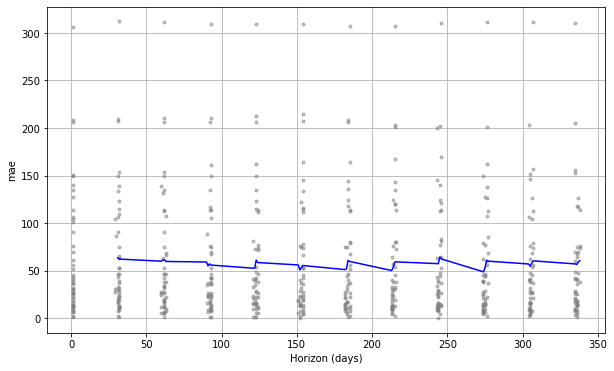

In [61]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_p = performance_metrics(df_cv)

fig = plot_cross_validation_metric(df_cv, metric='mae')

In [79]:
# Python
%%time
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here
maes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    print(params,'\n')
    m = Prophet(**params).fit(strain[strain.cd_estacao == 'A001'])  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=365)
    rmses.append(df_p['rmse'].values[0])
    maes.append(df_p['mae'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mae'] = maes

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7fb041803048>


{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01} 



INFO:fbprophet:Skipping MAPE because y close to 0


KeyError: ignored